<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="300" alt="cognitiveclass.ai logo">
</center>


# **Credit Card Fraud Detection using Scikit-Learn and Snap ML**


Estimated time needed: **30** minutes


In this exercise session you will consolidate your machine learning (ML) modeling skills by using two popular classification models to recognize fraudulent credit card transactions. These models are: Decision Tree and Support Vector Machine. You will use a real dataset to train each of these models. The dataset includes information about 
transactions made by credit cards in September 2013 by European cardholders. You will use the trained model to assess if a credit card transaction is legitimate or not.

In the current exercise session, you will practice not only the Scikit-Learn Python interface, but also the Python API offered by the Snap Machine Learning (Snap ML) library. Snap ML is a high-performance IBM library for ML modeling. It provides highly-efficient CPU/GPU implementations of linear models and tree-based models. Snap ML not only accelerates ML algorithms through system awareness, but it also offers novel ML algorithms with best-in-class accuracy. For more information, please visit [snapml](https://ibm.biz/BdPfxy) information page.


## Objectives


After completing this lab you will be able to:


* Perform basic data preprocessing in Python
* Model a classification task using the Scikit-Learn and Snap ML Python APIs
* Train Suppport Vector Machine and Decision Tree models using Scikit-Learn and Snap ML
* Run inference and assess the quality of the trained models


## Table of Contents


<div class="alert alert-block alert-info" style="margin-top: 10px">
    <ol>
        <li><a href="#introduction">Introduction</a></li>
        <li><a href="#import_libraries">Import Libraries</a></li>
        <li><a href="#dataset_analysis">Dataset Analysis</a></li>
        <li><a href="#dataset_preprocessing">Dataset Preprocessing</a></li>
        <li><a href="#dataset_split">Dataset Train/Test Split</a></li>
        <li><a href="#dt_sklearn">Build a Decision Tree Classifier model with Scikit-Learn</a></li>
        <li><a href="#dt_snap">Build a Decision Tree Classifier model with Snap ML</a></li>
        <li><a href="#dt_sklearn_snap">Evaluate the Scikit-Learn and Snap ML Decision Tree Classifiers</a></li>
        <li><a href="#svm_sklearn">Build a Support Vector Machine model with Scikit-Learn</a></li>
        <li><a href="#svm_snap">Build a Support Vector Machine model with Snap ML</a></li>
        <li><a href="#svm_sklearn_snap">Evaluate the Scikit-Learn and Snap ML Support Vector Machine Models</a></li>
    </ol>
</div>
<br>
<hr>


<div id="Introduction">
    <h2>Introduction</h2>
    <br>Imagine that you work for a financial institution and part of your job is to build a model that predicts if a credit card transaction is fraudulent or not. You can model the problem as a binary classification problem. A transaction belongs to the positive class (1) if it is a fraud, otherwise it belongs to the negative class (0).
    <br>
    <br>You have access to transactions that occured over a certain period of time. The majority of the transactions are normally legitimate and only a small fraction are non-legitimate. Thus, typically you have access to a dataset that is highly unbalanced. This is also the case of the current dataset: only 492 transactions out of 284,807 are fraudulent (the positive class - the frauds - accounts for 0.172% of all transactions).
    <br>
    <br>To train the model you can use part of the input dataset and the remaining data can be used to assess the quality of the trained model. First, let's download the dataset.
    <br>
</div>


In [2]:
# install the opendatasets package
!pip install opendatasets

import opendatasets as od

# download the dataset (this is a Kaggle dataset)
# during download you will be required to input your Kaggle username and password
od.download("https://www.kaggle.com/mlg-ulb/creditcardfraud")

Skipping, found downloaded files in "./creditcardfraud" (use force=True to force download)


__Did you know?__ When it comes to Machine Learning, you will most likely be working with large datasets. As a business, where can you host your data? IBM is offering a unique opportunity for businesses, with 10 Tb of IBM Cloud Object Storage: [Sign up now for free](https://ibm.biz/BdPfxf)


<div id="import_libraries">
    <h2>Import Libraries</h2>
</div>


In [3]:
# Snap ML is available on PyPI. To install it simply run the pip command below.
!pip install snapml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 74.0 MB/s eta 0:00:00:00:010:01


In [4]:
# Import the libraries we need to use in this lab
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_auc_score
import time
import warnings
warnings.filterwarnings('ignore')

/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


<div id="dataset_analysis">
    <h2>Dataset Analysis</h2>
</div>


In this section you will read the dataset in a Pandas dataframe and visualize its content. You will also look at some data statistics. 

Note: A Pandas dataframe is a two-dimensional, size-mutable, potentially heterogeneous tabular data structure. For more information: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html. 


In [5]:
# read the input data
raw_data = pd.read_csv('creditcardfraud/creditcard.csv')
print("There are " + str(len(raw_data)) + " observations in the credit card fraud dataset.")
print("There are " + str(len(raw_data.columns)) + " variables in the dataset.")

# display the first rows in the dataset
raw_data.head()

There are 284807 observations in the credit card fraud dataset.
There are 31 variables in the dataset.


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
#Uncomment the following lines if you are unable to download the dataset using the Kaggle website.

#url= "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/creditcard.csv"
#raw_data=pd.read_csv(url)
#print("There are " + str(len(raw_data)) + " observations in the credit card fraud dataset.")
#print("There are " + str(len(raw_data.columns)) + " variables in the dataset.")
#raw_data.head()

In practice, a financial institution may have access to a much larger dataset of transactions. To simulate such a case, we will inflate the original one 10 times.


In [6]:
n_replicas = 10

# inflate the original dataset
big_raw_data = pd.DataFrame(np.repeat(raw_data.values, n_replicas, axis=0), columns=raw_data.columns)

print("There are " + str(len(big_raw_data)) + " observations in the inflated credit card fraud dataset.")
print("There are " + str(len(big_raw_data.columns)) + " variables in the dataset.")

# display first rows in the new dataset
big_raw_data.head()

There are 2848070 observations in the inflated credit card fraud dataset.
There are 31 variables in the dataset.


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
2,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
3,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
4,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0


Each row in the dataset represents a credit card transaction. As shown above, each row has 31 variables. One variable (the last variable in the table above) is called Class and represents the target variable. Your objective will be to train a model that uses the other variables to predict the value of the Class variable. Let's first retrieve basic statistics about the target variable.

Note: For confidentiality reasons, the original names of most features are anonymized V1, V2 .. V28. The values of these features are the result of a PCA transformation and are numerical. The feature 'Class' is the target variable and it takes two values: 1 in case of fraud and 0 otherwise. For more information about the dataset please visit this webpage: https://www.kaggle.com/mlg-ulb/creditcardfraud.


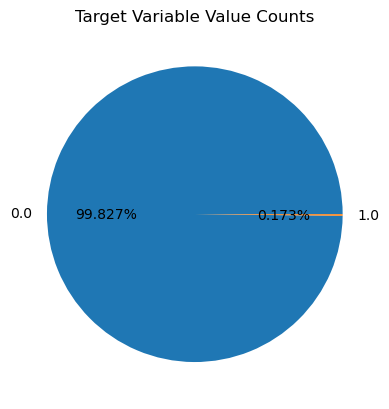

In [7]:
# get the set of distinct classes
labels = big_raw_data.Class.unique()

# get the count of each class
sizes = big_raw_data.Class.value_counts().values

# plot the class value counts
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.3f%%')
ax.set_title('Target Variable Value Counts')
plt.show()

As shown above, the Class variable has two values: 0 (the credit card transaction is legitimate) and 1 (the credit card transaction is fraudulent). Thus, you need to model a binary classification problem. Moreover, the dataset is highly unbalanced, the target variable classes are not represented equally. This case requires special attention when training or when evaluating the quality of a model. One way of handing this case at train time is to bias the model to pay more attention to the samples in the minority class. The models under the current study will be configured to take into account the class weights of the samples at train/fit time.


### Practice


The credit card transactions have different amounts. Could you plot a histogram that shows the distribution of these amounts? What is the range of these amounts (min/max)? Could you print the 90th percentile of the amount values?


<AxesSubplot:ylabel='Frequency'>

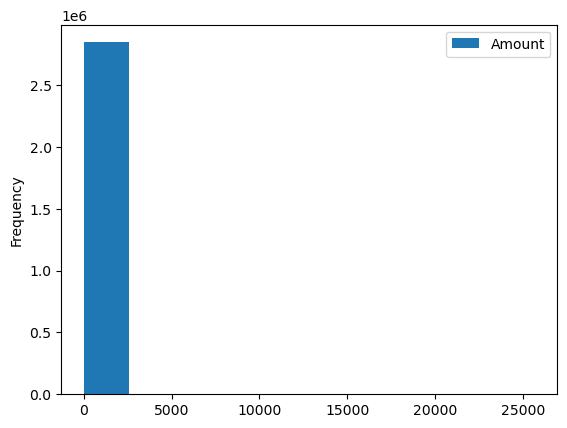

In [14]:
# your code here
big_raw_data.plot(kind='hist', y='Amount',x='Class' )

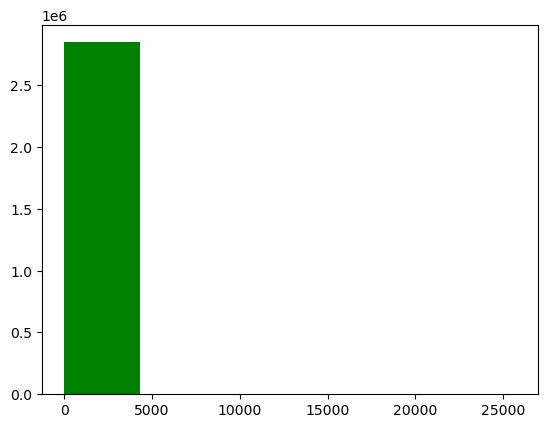

Minimum amount value is  0.0
Maximum amount value is  25691.16
90% of the transactions have an amount less or equal than  203.0


In [12]:
# we provide our solution here
plt.hist(big_raw_data.Amount.values, 6, histtype='bar', facecolor='g')
plt.show()

print("Minimum amount value is ", np.min(big_raw_data.Amount.values))
print("Maximum amount value is ", np.max(big_raw_data.Amount.values))
print("90% of the transactions have an amount less or equal than ", np.percentile(raw_data.Amount.values, 90))

<div id="dataset_preprocessing">
    <h2>Dataset Preprocessing</h2>
</div>


In this subsection you will prepare the data for training. 


In [15]:
# data preprocessing such as scaling/normalization is typically useful for 
# linear models to accelerate the training convergence

# standardize features by removing the mean and scaling to unit variance
big_raw_data.iloc[:, 1:30] = StandardScaler().fit_transform(big_raw_data.iloc[:, 1:30])
data_matrix = big_raw_data.values

# X: feature matrix (for this analysis, we exclude the Time variable from the dataset)
X = data_matrix[:, 1:30]

# y: labels vector
y = data_matrix[:, 30]

# data normalization
X = normalize(X, norm="l1")

# print the shape of the features matrix and the labels vector
print('X.shape=', X.shape, 'y.shape=', y.shape)

X.shape= (2848070, 29) y.shape= (2848070,)


<div id="dataset_split">
    <h2>Dataset Train/Test Split</h2>
</div>


Now that the dataset is ready for building the classification models, you need to first divide the pre-processed dataset into a subset to be used for training the model (the train set) and a subset to be used for evaluating the quality of the model (the test set).


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)       
print('X_train.shape=', X_train.shape, 'Y_train.shape=', y_train.shape)
print('X_test.shape=', X_test.shape, 'Y_test.shape=', y_test.shape)

<div id="dt_sklearn">
    <h2>Build a Decision Tree Classifier model with Scikit-Learn</h2>
</div>


In [ ]:
# compute the sample weights to be used as input to the train routine so that 
# it takes into account the class imbalance present in this dataset
w_train = compute_sample_weight('balanced', y_train)

# import the Decision Tree Classifier Model from scikit-learn
from sklearn.tree import DecisionTreeClassifier

# for reproducible output across multiple function calls, set random_state to a given integer value
sklearn_dt = DecisionTreeClassifier(max_depth=4, random_state=35)

# train a Decision Tree Classifier using scikit-learn
t0 = time.time()
sklearn_dt.fit(X_train, y_train, sample_weight=w_train)
sklearn_time = time.time()-t0
print("[Scikit-Learn] Training time (s):  {0:.5f}".format(sklearn_time))

<div id="dt_snapml">
    <h2>Build a Decision Tree Classifier model with Snap ML</h2>
</div>


In [ ]:
# if not already computed, 
# compute the sample weights to be used as input to the train routine so that 
# it takes into account the class imbalance present in this dataset
# w_train = compute_sample_weight('balanced', y_train)

# import the Decision Tree Classifier Model from Snap ML
from snapml import DecisionTreeClassifier

# Snap ML offers multi-threaded CPU/GPU training of decision trees, unlike scikit-learn
# to use the GPU, set the use_gpu parameter to True
# snapml_dt = DecisionTreeClassifier(max_depth=4, random_state=45, use_gpu=True)

# to set the number of CPU threads used at training time, set the n_jobs parameter
# for reproducible output across multiple function calls, set random_state to a given integer value
snapml_dt = DecisionTreeClassifier(max_depth=4, random_state=45, n_jobs=4)

# train a Decision Tree Classifier model using Snap ML
t0 = time.time()
snapml_dt.fit(X_train, y_train, sample_weight=w_train)
snapml_time = time.time()-t0
print("[Snap ML] Training time (s):  {0:.5f}".format(snapml_time))

<div id="dt_sklearn_snapml">
    <h2>Evaluate the Scikit-Learn and Snap ML Decision Tree Classifier Models</h2>
</div>


In [ ]:
# Snap ML vs Scikit-Learn training speedup
training_speedup = sklearn_time/snapml_time
print('[Decision Tree Classifier] Snap ML vs. Scikit-Learn speedup : {0:.2f}x '.format(training_speedup))

# run inference and compute the probabilities of the test samples 
# to belong to the class of fraudulent transactions
sklearn_pred = sklearn_dt.predict_proba(X_test)[:,1]

# evaluate the Compute Area Under the Receiver Operating Characteristic 
# Curve (ROC-AUC) score from the predictions
sklearn_roc_auc = roc_auc_score(y_test, sklearn_pred)
print('[Scikit-Learn] ROC-AUC score : {0:.3f}'.format(sklearn_roc_auc))

# run inference and compute the probabilities of the test samples
# to belong to the class of fraudulent transactions
snapml_pred = snapml_dt.predict_proba(X_test)[:,1]

# evaluate the Compute Area Under the Receiver Operating Characteristic
# Curve (ROC-AUC) score from the prediction scores
snapml_roc_auc = roc_auc_score(y_test, snapml_pred)   
print('[Snap ML] ROC-AUC score : {0:.3f}'.format(snapml_roc_auc))

As shown above both decision tree models provide the same score on the test dataset. However Snap ML runs the training routine 12x faster than Scikit-Learn. This is one of the advantages of using Snap ML: acceleration of training of classical machine learning models, such as linear and tree-based models. For more Snap ML examples, please visit [snapml-examples](https://ibm.biz/BdPfxP).


<div id="svm_sklearn">
    <h2>Build a Support Vector Machine model with Scikit-Learn</h2>
</div>


In [ ]:
# import the linear Support Vector Machine (SVM) model from Scikit-Learn
from sklearn.svm import LinearSVC

# instatiate a scikit-learn SVM model
# to indicate the class imbalance at fit time, set class_weight='balanced'
# for reproducible output across multiple function calls, set random_state to a given integer value
sklearn_svm = LinearSVC(class_weight='balanced', random_state=31, loss="hinge", fit_intercept=False)

# train a linear Support Vector Machine model using Scikit-Learn
t0 = time.time()
sklearn_svm.fit(X_train, y_train)
sklearn_time = time.time() - t0
print("[Scikit-Learn] Training time (s):  {0:.2f}".format(sklearn_time))

<div id="svm_snap">
    <h2>Build a Support Vector Machine model with Snap ML</h2>
</div>


In [ ]:
# import the Support Vector Machine model (SVM) from Snap ML
from snapml import SupportVectorMachine

# in contrast to scikit-learn's LinearSVC, Snap ML offers multi-threaded CPU/GPU training of SVMs
# to use the GPU, set the use_gpu parameter to True
# snapml_svm = SupportVectorMachine(class_weight='balanced', random_state=25, use_gpu=True, fit_intercept=False)

# to set the number of threads used at training time, one needs to set the n_jobs parameter
snapml_svm = SupportVectorMachine(class_weight='balanced', random_state=25, n_jobs=4, fit_intercept=False)
# print(snapml_svm.get_params())

# train an SVM model using Snap ML
t0 = time.time()
model = snapml_svm.fit(X_train, y_train)
snapml_time = time.time() - t0
print("[Snap ML] Training time (s):  {0:.2f}".format(snapml_time))

<div id="svm_sklearn_snap">
    <h2>Evaluate the Scikit-Learn and Snap ML Support Vector Machine Models</h2>
</div>


In [ ]:
# compute the Snap ML vs Scikit-Learn training speedup
training_speedup = sklearn_time/snapml_time
print('[Support Vector Machine] Snap ML vs. Scikit-Learn training speedup : {0:.2f}x '.format(training_speedup))

# run inference using the Scikit-Learn model
# get the confidence scores for the test samples
sklearn_pred = sklearn_svm.decision_function(X_test)

# evaluate accuracy on test set
acc_sklearn  = roc_auc_score(y_test, sklearn_pred)
print("[Scikit-Learn] ROC-AUC score:   {0:.3f}".format(acc_sklearn))

# run inference using the Snap ML model
# get the confidence scores for the test samples
snapml_pred = snapml_svm.decision_function(X_test)

# evaluate accuracy on test set
acc_snapml  = roc_auc_score(y_test, snapml_pred)
print("[Snap ML] ROC-AUC score:   {0:.3f}".format(acc_snapml))

As shown above both SVM models provide the same score on the test dataset. However, as in the case of decision trees, Snap ML runs the training routine faster than Scikit-Learn. For more Snap ML examples, please visit [snapml-examples](https://ibm.biz/BdPfxP). Moreover, as shown above, not only is Snap ML seemlessly accelerating scikit-learn applications, but the library's Python API is also compatible with scikit-learn metrics and data preprocessors.


### Practice


In this section you will evaluate the quality of the SVM models trained above using the hinge loss metric (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.hinge_loss.html). Run inference on the test set using both Scikit-Learn and Snap ML models. Compute the hinge loss metric for both sets of predictions. Print the hinge losses of Scikit-Learn and Snap ML.


In [ ]:
# your code goes here

In [ ]:
# get the confidence scores for the test samples
sklearn_pred = sklearn_svm.decision_function(X_test)
snapml_pred  = snapml_svm.decision_function(X_test)

# import the hinge_loss metric from scikit-learn
from sklearn.metrics import hinge_loss

# evaluate the hinge loss from the predictions
loss_snapml = hinge_loss(y_test, snapml_pred)
print("[Snap ML] Hinge loss:   {0:.3f}".format(loss_snapml))

# evaluate the hinge loss metric from the predictions
loss_sklearn = hinge_loss(y_test, sklearn_pred)
print("[Scikit-Learn] Hinge loss:   {0:.3f}".format(loss_snapml))

# the two models should give the same Hinge loss

## Authors


Andreea Anghel


### Other Contributors


Joseph Santarcangelo


## Change Log


|  Date (YYYY-MM-DD) |  Version | Changed By  |  Change Description |
|---|---|---|---|
| 2021-08-31  | 0.1  | AAN  |  Created Lab Content |


 Copyright &copy; 2021 IBM Corporation. This notebook and its source code are released under the terms of the [MIT License](https://cognitiveclass.ai/mit-license/).
